In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import random
import pickle
import gzip

import time
import datetime

from sklearn.utils.extmath import cartesian

## Load the data

In [2]:
import pickle

with open('mnist.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train, valid, test = u.load()

train_x, train_y = train
valid_x, valid_y = valid
test_x, test_y = test

train_x = train_x.reshape(50000,28,28)
valid_x = valid_x.reshape(10000,28,28)
test_x = test_x.reshape(10000,28,28)

train_data = torch.FloatTensor(train_x)
train_data_ = Variable(train_data.view(-1,784))
train_labels = torch.FloatTensor(train_y).long()
train_labels_ = Variable(train_labels.view(-1))

valid_data = torch.FloatTensor(valid_x)
valid_data_ = Variable(valid_data.view(-1,784))
valid_labels = torch.FloatTensor(valid_y).long()
valid_labels_ = Variable(valid_labels.view(-1))

test_data = torch.FloatTensor(test_x)
test_data_ = Variable(valid_data.view(-1,784))
test_labels = torch.FloatTensor(test_y).long()
test_labels_ = Variable(valid_labels.view(-1))


# The model

In [3]:
def flatten(x):
    return x.view(x.size()[0], -1)
    
def adjust_lr(optimizer,lrs, epoch, total_epochs):
    lr = lrs * (0.36 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def prediction(data_batch,model):
    correct = 0
    total = 0
    for images, labels in data_batch:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return 100* correct / total

def batch_loss(data_batch,model,criterion): 
    loss = 0
    total = 0
    for batch_idx, (images,labels) in enumerate(data_batch):
#     for images, labels in data_batch:
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)  
        outputs = model(images)
        loss += criterion(outputs, labels)
        total += labels.size(0)
        
    return loss.data[0]/total

In [4]:
def linear_ini(LL,initialization):
    '''
    inputs : linear layer (LL) and the initialization
    output : linear layer with the chosen initialization
    '''
    if initialization == 'zero':
        LL.weight.data = nn.init.constant(LL.weight.data, 0)
        LL.bias.data = nn.init.constant(LL.bias.data, 0)
    
    if initialization == 'normal':
        LL.weight.data = nn.init.normal(LL.weight.data, 0,1)
        LL.bias.data = nn.init.constant(LL.bias.data, 0)

    if initialization == 'glorot':
        LL.weight.data = nn.init.xavier_uniform(LL.weight.data, gain=1)
        # that is important, see paper. 
        LL.bias.data = nn.init.constant(LL.bias.data, 0)
    if initialization == 'default': 
        pass
    return LL


class MLPLinear(nn.Module):
	def __init__(self, dimensions, cuda):
		super(MLPLinear, self).__init__()
		self.h0 = int(dimensions[0])
		self.h1 = int(dimensions[1])
		self.h2 = int(dimensions[2])       
		self.h3 = int(dimensions[3])

		self.fc1 = torch.nn.Linear(self.h0,self.h1)
		self.fc2 = torch.nn.Linear(self.h1,self.h2)        
		self.fc3 = torch.nn.Linear(self.h2,self.h3)                
		self.relu = nn.ReLU()
		self.criterion = nn.CrossEntropyLoss()
		self.cuda = cuda

		if cuda: 
			self.fc1.cuda()
			self.fc2.cuda()
			self.fc3.cuda()            
			self.relu.cuda()
			self.criterion.cuda()

	def initialization(self,method):
		self.fc1 = linear_ini(self.fc1,method)
		self.fc2 = linear_ini(self.fc2,method)
		self.fc3 = linear_ini(self.fc3,method)        

	def input(self,x,y):
		x = (x.view(-1,784))
		y = (y)  
		if self.cuda : 
			x = Variable(x.cuda())
			y = Variable(y.cuda())
		else: 
			x = Variable(x)
			y = Variable(y)
		return x,y
        
    
	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		out = self.relu(out)        
		out = self.fc3(out)        
		return  out
    


# Initialization

In [6]:
# important information 
cuda = False
batch_size = 100
num_epochs = 10
lr0 = 0.1

h0 = 28*28    #784
h1 = b1 = 500
h2 = b2 = 300
h3 = b3 = 10
initialization_method = ['default','zero','normal','glorot']


print('Number of parameters = '+str((h0*h1 + h1*h2 + h2*h3 + b1 + b2 + b3)/1E6)+'M')
model = MLPLinear([h0,h1,h2,h3],cuda) 
xx,yy = model.input(train_data,train_labels)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print('Number of parameters = '+str(params/1e6)+'M')

Number of parameters = 0.54581M
Number of parameters = 0.54581M


In [134]:
cuda = False
initialization_method = ['default','zero','normal','glorot']

n = len(initialization_method)
m = num_epochs

loss_train = np.empty([n,m]) 
loss_valid = np.empty([n,m]) 

acc_train = np.empty([n,m]) 
acc_valid = np.empty([n,m]) 

train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data,train_labels), batch_size=batch_size, shuffle=True)
valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=False)
test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data,test_labels), batch_size=batch_size, shuffle=False)

t0 = time.time()        
for i, method in enumerate(initialization_method):
    model = MLPLinear([h0,h1,h2,h3],cuda) 
    model.initialization(method)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    print('     ')
    print('     ')    
    print('Initialization method : '+method)
    print('________________________________')    
    for j in range(num_epochs):
        model_loss = 0
        for batch_idx, (x,y) in enumerate(train_batch):
            xt,yt = model.input(x,y)
            pred_batch = model.forward(xt)
            
            optimizer.zero_grad()
            loss_batch = model.criterion(pred_batch, yt)
            loss_batch.backward()
            optimizer.step()

        xt_,yt_ = model.input(train_data,train_labels)
        xv_,yv_ = model.input(valid_data,valid_labels)
        pred_train_all = model.forward(xt_)
        pred_valid_all = model.forward(xv_)  
        
        loss_train[i,j] = model.criterion(pred_train_all,yt_).data[0]
        loss_valid[i,j] = model.criterion(pred_valid_all,yv_).data[0]

        acc_train[i,j]  = prediction(train_batch,model)
        acc_valid[i,j]  = prediction(valid_batch,model)
        
        if j%4==0: print('Epoch #'+str(j)+', Train loss = '+str(loss_train[i,j])+', Valid loss = '+str(loss_valid[i,j]))
        
    print('Train accuracy = '+str(prediction(train_batch,model))+'%')
    ts = time.time()        
    print('Time : %.1f sec'%(ts-t0))
print('done!')

     
     
Initialization method : default
________________________________
Epoch #0, Train loss = 1.63850140572, Valid loss = 1.62412583828
Epoch #4, Train loss = 0.366875976324, Valid loss = 0.336970359087
Epoch #8, Train loss = 0.295644849539, Valid loss = 0.275731414557
Train accuracy = 91.908%
Time : 37.7 sec
     
     
Initialization method : zero
________________________________
Epoch #0, Train loss = 2.30146503448, Valid loss = 2.30203080177
Epoch #4, Train loss = 2.30095291138, Valid loss = 2.30195355415
Epoch #8, Train loss = 2.30118250847, Valid loss = 2.30195093155
Train accuracy = 11.356%
Time : 72.2 sec
     
     
Initialization method : normal
________________________________
Epoch #0, Train loss = 16.452495575, Valid loss = 19.1043224335
Epoch #4, Train loss = 2.95227026939, Valid loss = 8.07720279694
Epoch #8, Train loss = 1.14590752125, Valid loss = 6.66162967682
Train accuracy = 97.466%
Time : 112.4 sec
     
     
Initialization method : glorot
__________________

In [3]:
# filename = 'SaveData/Q1/Init_methods_tests_3'
# with open(filename, 'wb') as f: 
#     pickle.dump([loss_train, loss_valid, acc_train, acc_valid, lr0, h1, h2, batch_size], f)
    

NameError: name 'loss_train' is not defined

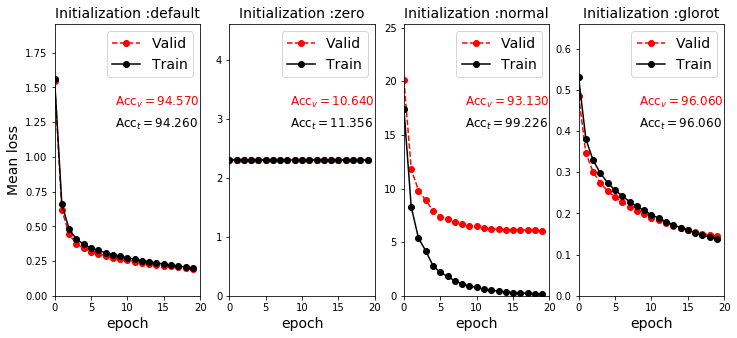

In [7]:
with open('SaveData/Q1/Init_methods_tests_2', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, lr, h1, h2, batch_size  = pickle.load(f)

# print('lr_0 = '+str(lr))
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,5))
ax = [ax1,ax2,ax3,ax4]
for i,(ax_,initialization_method_) in enumerate(zip(ax,initialization_method)): 
    
    ax_.plot(loss_valid[i,:],'o--',label=initialization_method[0],color='r')
    ax_.plot(loss_train[i,:],'o-',label=initialization_method[0],color='k')

    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Valid','Train'],loc='upper right',fontsize=14)
    ax_.set_title('Initialization :'+initialization_method_,fontsize=14)
    

    if i==1:ax_.set_ylim(ymin=0,ymax=2*ax_.get_ylim()[1])
    if i!=1:ax_.set_ylim(ymin=0,ymax=1.2*ax_.get_ylim()[1])
    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    ax_.text(0.4*coordinates[0],0.7*coordinates[1], 'Acc$_{v} = $%.3f %%' %acc_valid[i,-1], fontsize=12,color='r',clip_on=True)
    ax_.text(0.4*coordinates[0],0.62*coordinates[1], 'Acc$_{t} = $%.3f %%' %acc_train[i,-1], fontsize=12,clip_on=True)    
    ax_.set_xlim((0,20))
ax1.set_ylabel('Mean loss',fontsize=14)

plt.show()          

fig.savefig('Figures/Q1_Initialization.pdf')

array([ 86.74 ,  89.708,  90.626,  91.564,  92.27 ,  92.7  ,  93.154,
        93.57 ,  93.868,  94.168,  94.466,  94.698,  94.938,  95.124,
        95.378,  95.48 ,  95.658,  95.844,  95.954,  96.06 ])

In [8]:
print('Accuracy - Train')
print('________________')
print('Initialization - zero ='+str(acc_train[0,-1])+'%')
print('Initialization - normal ='+str(acc_train[1,-1])+'%')
print('Initialization - glorot ='+str(acc_train[2,-1])+'%')
print('Initialization - none ='+str(acc_train[3,-1])+'%')
print('     ')
print('     ')
print('Accuracy - Valid')
print('________________')
print('Initialization - zero ='+str(acc_valid[0,-1])+'%')
print('Initialization - normal ='+str(acc_valid[1,-1])+'%')
print('Initialization - glorot ='+str(acc_valid[2,-1])+'%')
print('Initialization - none ='+str(acc_valid[3,-1])+'%')



Accuracy - Train
________________
Initialization - zero =94.26%
Initialization - normal =11.356%
Initialization - glorot =99.226%
Initialization - none =96.06%
     
     
Accuracy - Valid
________________
Initialization - zero =94.57%
Initialization - normal =10.64%
Initialization - glorot =93.13%
Initialization - none =96.06%


# Learning Curves

## Search for the optimal hyperparameters.

In [20]:
np.random.seed(seed=None)

cuda = False
batch_size = 100
num_epochs = 1
lr0 = 0.1

h0 = 28*28    #784
h1 = b1 = 500
h2 = b2 = 300
h3 = b3 = 10

nb_hp = 1
hyperparameters=np.empty((nb_hp,4))
for i in range(nb_hp):
    hyperparameters[i,:] = np.concatenate((
        np.random.randint(300,800,1),
        np.random.randint(300,800,1),
        np.random.randint(20,200,1),        
        np.random.uniform(0.0001,0.1,1)
    )).reshape(1,4)

# initialization_method = ['default','zero','normal','glorot']    

hp = []
for i,h in enumerate(hyperparameters):
    hp.append([h[0],h[1],h[2],h[3],'default'])
for i,h in enumerate(hyperparameters):    
    hp.append([h[0],h[1],h[2],h[3],'zero'])
for i,h in enumerate(hyperparameters):    
    hp.append([h[0],h[1],h[2],h[3],'normal'])    
for i,h in enumerate(hyperparameters):    
    hp.append([h[0],h[1],h[2],h[3],'glorot'])        


__We ran sixty different hyperparameters on GPUs. The data was pickled in the file called 'Hunt for best hyperparameters - Q1'. The results are printed and plotted below. __ 

In [9]:
with open('SaveData/Q1/Hunt for best hyperparameters - Q1', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)

max=0
for i, (acc_,hp_) in enumerate(zip(acc_valid,hp)):
    if hp_[4] == 'default':
        pass
    else:
        max_acc = np.max(acc_)
        if max_acc > max:
            max = max_acc
            h_star = hp_



print('best hyperparameters are : ')
print(h_star)


best hyperparameters are : 
[787.0, 437.0, 77.0, 0.088607443091241619, 'glorot']


In [ ]:
hp = [[2*787, 2*437, 77, 0.088607443091241619, 'glorot'],]

cuda = False
n = len(hp)
m = num_epochs

loss_train = np.empty([n,m]) 
loss_valid = np.empty([n,m]) 

acc_train = np.empty([n,m]) 
acc_valid = np.empty([n,m]) 
lr = np.empty([n,m]) 

t0 = time.time()        
for i, (h1s, h2s, bs, lrs, method_) in enumerate(hp):
    
    train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data,train_labels), batch_size=bs, shuffle=True)
    valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=bs, shuffle=False)
    test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data,test_labels), batch_size=bs, shuffle=False)

    model = MLPLinear([h0,h1s,h2s,h3],cuda) 
    model.initialization(method_)
    optimizer = optim.SGD(model.parameters(), lr=lrs)
    
    print('     ')
    print('     ')    
    print('Initialization method : '+method_)
    print('________________________________')    
    for j in range(num_epochs):
        model_loss = 0
        for batch_idx, (x,y) in enumerate(train_batch):
            xt,yt = model.input(x,y)
            pred_batch = model.forward(xt)
            
            optimizer.zero_grad()
            loss_batch = model.criterion(pred_batch, yt)
            loss_batch.backward()
            optimizer.step()
        
        xt_,yt_ = model.input(train_data,train_labels)
        xv_,yv_ = model.input(valid_data,valid_labels)
        pred_train_all = model.forward(xt_)
        pred_valid_all = model.forward(xv_)  
        
        loss_train[i,j] = model.criterion(pred_train_all,yt_).data[0]
        loss_valid[i,j] = model.criterion(pred_valid_all,yv_).data[0]

        acc_train[i,j]  = prediction(train_batch,model)
        acc_valid[i,j]  = prediction(valid_batch,model)
        
        if j%10 ==0: print('Epoch #'+str(j)+', Train loss = '+str(loss_train[i,j])+', Valid loss = '+str(loss_valid[i,j]))
        lr[i,j] = adjust_lr(optimizer,lrs, j+1, num_epochs)
    print('Train accuracy = '+str(prediction(train_batch,model))+'%')
    ts = time.time()        
    print('Time :  %.1f sec'%(ts-t0))
print('done!')


In [22]:
# filename = 'SaveData/Q1/LearningRate_best_HP_doubled'
# with open(filename, 'wb') as f: 
#     pickle.dump([loss_train, loss_valid, acc_train, acc_valid,hp], f)

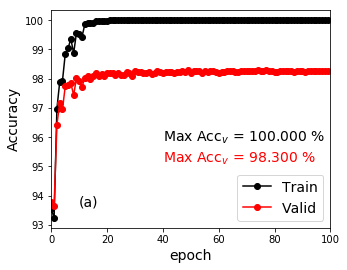

In [11]:
with open('SaveData/Q1/LearningCurve_best_HP', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)
    

fig, (ax1) = plt.subplots(1,figsize=(5,4))
ax = [ax1]
# text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0])]


for i, ax_ in enumerate(ax): 

    ax_.plot(acc_train[i,:],'o-',label=initialization_method[0],color='k')
    ax_.plot(acc_valid[i,:],'o-',label=initialization_method[0],color='r')
    
    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Train','Valid'],loc='lower right',fontsize=14)
    ax_.set_xlim([0,100])


    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    xmin, xmax = ax_.get_xlim()
    ymin, ymax = ax_.get_ylim()
    ax_.text(0.1*(xmax - xmin) + xmin, 0.1*(ymax-ymin) + ymin,'(a)', fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.4*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_train), fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.3*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_valid), fontsize=14,color='r')

#     ax_.text(0.4*coordinates[0],0.7*coordinates[1], , fontsize=12,color='r')    

ax1.set_ylabel('Accuracy',fontsize=14)
plt.show()  

fig.savefig('Figures/Q1_Best_HP.pdf')

Parameters are : h1 = 1574, h2 = 874, batch size = 77


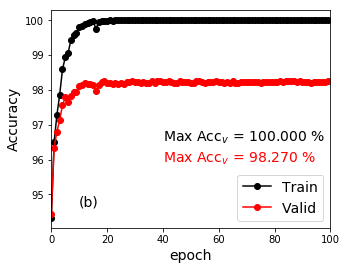

In [12]:
with open('SaveData/Q1/LearningCurve_best_HP_double', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)
    
print('Parameters are : h1 = %.f, h2 = %.f, batch size = %.f'%(hp[0][0],hp[0][1],hp[0][2]))
    

fig, (ax1) = plt.subplots(1,figsize=(5,4))
ax = [ax1]
# text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0])]


for i, ax_ in enumerate(ax): 

    ax_.plot(acc_train[i,:],'o-',label=initialization_method[0],color='k')
    ax_.plot(acc_valid[i,:],'o-',label=initialization_method[0],color='r')
    
    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Train','Valid'],loc='lower right',fontsize=14)
    ax_.set_xlim([0,100])


    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    xmin, xmax = ax_.get_xlim()
    ymin, ymax = ax_.get_ylim()
    ax_.text(0.1*(xmax - xmin) + xmin, 0.1*(ymax-ymin) + ymin,'(b)', fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.4*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_train), fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.3*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_valid), fontsize=14,color='r')

#     ax_.text(0.4*coordinates[0],0.7*coordinates[1], , fontsize=12,color='r')    

ax1.set_ylabel('Accuracy',fontsize=14)
plt.show()  

fig.savefig('Figures/Q1_Best_HP_double.pdf')

Parameters are : h1 = 3935, h2 = 1748, batch size = 77


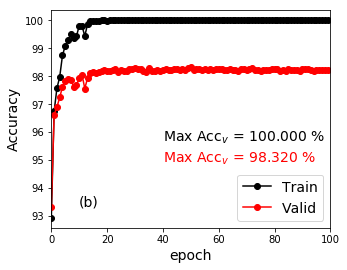

In [13]:
with open('SaveData/Q1/LearningCurve_best_HP_VeryBig', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)
    
print('Parameters are : h1 = %.f, h2 = %.f, batch size = %.f'%(hp[0][0],hp[0][1],hp[0][2]))
    

fig, (ax1) = plt.subplots(1,figsize=(5,4))
ax = [ax1]
# text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0])]


for i, ax_ in enumerate(ax): 

    ax_.plot(acc_train[i,:],'o-',label=initialization_method[0],color='k')
    ax_.plot(acc_valid[i,:],'o-',label=initialization_method[0],color='r')
    
    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Train','Valid'],loc='lower right',fontsize=14)
    ax_.set_xlim([0,100])


    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    xmin, xmax = ax_.get_xlim()
    ymin, ymax = ax_.get_ylim()
    ax_.text(0.1*(xmax - xmin) + xmin, 0.1*(ymax-ymin) + ymin,'(b)', fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.4*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_train), fontsize=14,color='k')        
    ax_.text(0.4*(xmax - xmin) + xmin, 0.3*(ymax-ymin) + ymin,'Max Acc$_v$ = %.3f %%'%np.max(acc_valid), fontsize=14,color='r')

#     ax_.text(0.4*coordinates[0],0.7*coordinates[1], , fontsize=12,color='r')    

ax1.set_ylabel('Accuracy',fontsize=14)
plt.show()  

fig.savefig('Figures/Q1_Best_HP_VeryBig.pdf')

## Training Set Size, Generalization Gap, and Standard Error

In [ ]:



#### GAP
cuda  = True
#hp = [[2*787, 2437, 77, 0.088607443091241619, 'glorot'],]
h0 = 28*28
h1 = 787
h2 = 437
h3 = 10
lr0 = 0.0886
num_epochs = 100
batch_size = 77
a = [0.01, 0.02, 0.05, 0.1, 1.0]
T = 5

initialization_method = ['glorot']

loss_valid_all=np.empty([T,len(a),num_epochs])
loss_train_all=np.empty([T,len(a),num_epochs])
loss_test_all=np.empty([T,len(a),num_epochs])
acc_valid_all=np.empty([T,len(a),num_epochs])
acc_train_all=np.empty([T,len(a),num_epochs])
acc_test_all=np.empty([T,len(a),num_epochs])


for i in range(T):
    print(str(i+1)+'/5')
    for j,a_ in enumerate(a):
        ind = torch.randperm(int(a_*50000))
        train_data_subset = train_data[ind]
        train_labels_subset = torch.FloatTensor(train_y[ind]).long()

        train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data_subset,train_labels_subset), batch_size=batch_size, shuffle=True)
        valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=False)
        test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data,test_labels), batch_size=batch_size, shuffle=False)
        
        model = MLPLinear([h0,h1,h2,h3],cuda) 
        model.initialization('glorot')
        optimizer = optim.SGD(model.parameters(), lr=lr0)
            
        loss_train = np.array([])
        loss_valid = np.array([])
        loss_test = np.array([])

        acc_train = np.array([])
        acc_valid = np.array([])
        acc_test = np.array([])
        lr = np.array([])
        
        for k in range(num_epochs):
            for batch_idx, (x,y) in enumerate(train_batch):
                xt,yt = model.input(x,y)
                pred_batch = model.forward(xt)
            
                optimizer.zero_grad()
                loss_batch = model.criterion(pred_batch, yt)
                loss_batch.backward()
                optimizer.step()    
            
            xt_,yt_ = model.input(train_data,train_labels)
            xv_,yv_ = model.input(valid_data,valid_labels)
            xte_,yte_ = model.input(test_data,test_labels)
            pred_train_all = model.forward(xt_)
            pred_valid_all = model.forward(xv_)  
            pred_test_all = model.forward(xte_)  
        
            
            loss_valid = np.append(loss_valid,model.criterion(pred_valid_all,yv_).data[0])
            loss_train = np.append(loss_train,model.criterion(pred_train_all,yt_).data[0])
            loss_test = np.append(loss_test,model.criterion(pred_test_all,yte_).data[0])
            acc_valid  = np.append(acc_valid,prediction(valid_batch,model))
            acc_train  = np.append(acc_train,prediction(train_batch,model))
            acc_test  = np.append(acc_test,prediction(test_batch,model))
            lr_ = adjust_lr(optimizer,lr0, j+1, num_epochs)
            lr = np.append(lr,lr_)
              
            if k%20 == 0:
                print('Epoch #'+str(k)+', Train loss = '+str(loss_train[k])+', Valid loss = '+str(loss_valid[k])+', lr = '+str(lr[k]))
        
        print('Train accuracy = '+str(prediction(train_batch,model))+'%'+',  Valid accuracy = '+str(prediction(valid_batch,model))+'%')        

    
        loss_train_all[i,j,:] = loss_train
        loss_valid_all[i,j:] = loss_valid
        loss_test_all[i,j:] = loss_test
        acc_train_all[i,j:] = acc_train
        acc_valid_all[i,j:] = acc_valid
        acc_test_all[i,j:] = acc_test



print('Done!')



# filename = ''Generalize_Gap
# with open(filename, 'wb') as f: 
#     pickle.dump([loss_train_all, loss_valid_all,loss_test_all, acc_train_all, acc_valid_all,acc_test_all,h1,h2,batch_size,lr0], f)



In [14]:
with open('SaveData/Q1/Generalize_Gap_v4', 'rb') as f:
    loss_train_all, loss_valid_all,loss_test_all, acc_train_all, acc_valid_all,acc_test_all,h1,h2,batch_size,lr0  = pickle.load(f)
    

epoch_star = np.argmax(acc_valid_all,axis=2)
gap = np.empty((5,5))
for i in range(5):
    for j in range(5):
        e_ = epoch_star[i,j]
        gap[i,j] = acc_train_all[i,j,e_] - acc_test_all[i,j,e_]
        




[   500.   1000.   2500.   5000.  50000.]


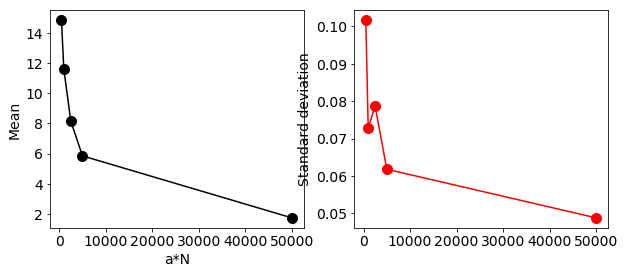

In [15]:
gap_mean = np.mean(gap,axis=0)
gap_std = np.std(gap,axis=0)
NT = 50000*np.array((0.01, 0.02, 0.05, 0.1, 1.0))
print(NT)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.plot(NT,gap_mean,'-ko',markersize=10)
ax2.plot(NT,gap_std,'-ro',markersize=10)
            
ax1.set_ylabel('Mean',fontsize=14)
ax2.set_ylabel('Standard deviation',fontsize=14)
ax1.set_xlabel('a*N',fontsize=14)
# ax1.set_title('Hyperparameters random search')

for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        
plt.show()        

fig.savefig('Figures/Gap.pdf')

 

In [16]:
print(gap)
print(gap_mean)
print(gap_std)

[[ 14.9   11.5    8.1    5.83   1.83]
 [ 14.73  11.67   8.14   5.84   1.68]
 [ 14.78  11.69   8.05   5.96   1.74]
 [ 14.72  11.54   8.26   5.86   1.76]
 [ 14.98  11.6    8.23   5.77   1.73]]
[ 14.822  11.6     8.156   5.852   1.748]
[ 0.10166612  0.07293833  0.07863841  0.06177378  0.04874423]


## LOG 
### Data files for hyper-parameter analysis 

* Data_MNIST_GLOROT_150bs : lr0 = 0.2 Might be too large. 99% after only 9 epochs. Did not save the h2, h3 and batchsize in pickle
* Data_MNIST_GLOROT_100bs : lr0 = 0.2 Might be too large. 99% after only 9 epochs. 

* Data_MNIST_GLOROT_100bs : lr0 = 0.15 Might be too large. 99% after only 9 epochs. h1 = 500 and h2 = 400
* Data_MNIST_GLOROT_50bs : lr0 = 0.1, h1 = b1 = [300,500,800], h2 = b2 = [200,400,700]
* Data_MNIST_GLOROT_100bs : lr0 = 0.1, h1 = b1 = [300,500,800], h2 = b2 = [200,400,700]
* Data_MNIST_GLOROT_100bs : lr0 = 0.01, h1 = b1 = [500], h2 = b2 = [400] - to reproduce the previous results. Data_MNIST_GLOROT_100bs_2018-02-06 22h47m41s - lr = 0.01 - too slow. 
* Data_MNIST_GLOROT_100bs : lr0 = 0.1, h1 = b1 = [500], h2 = b2 = [400] - to reproduce the previous results. Data_MNIST_GLOROT_100bs_2018-02-06 22h57m10s - lr = 0.1. 
* Data_MNIST_GLOROT_100bs : lr0 = 0.1, h1 = b1 = 2*[500] = 1000, h2 = b2 = 2*[400] = 800 - with twice the capacity




In [ ]:
# with open('Data_MNIST_GLOROT_50bs_2018-02-06 15h39m31s', 'rb') as f:
#     loss_train, loss_valid, acc_train, acc_valid, lr, h1, h2, batch_size  = pickle.load(f)



fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,6))
ax = [ax1,ax2,ax3]
text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0]),'$h_1 = $'+str(h1[1])+', $h_2 = $'+str(h1[1]),'$h_1 = $'+str(h1[2])+', $h_2 = $'+str(h1[2])]
h_star = [10,6,10]

for i, (ax_,text_,h_star_) in enumerate(zip(ax,text,h_star)): 
    color = next(ax_._get_lines.prop_cycler)['color']
    ax_.plot(loss_valid[0,i,i,:],'o--',label=initialization_method[0],color='r')
    ax_.plot(loss_train[0,i,i,:],'o-',label=initialization_method[0],color='k')
    
    ax_.set_xlabel('epoch',fontsize=14)

    legend = ax_.legend(['Valid','Train'],loc='upper right',fontsize=14)
    ax_.set_xlim([0,40])
    ax_.set_ylim([0,0.18])

    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    ax_.text(0.4*coordinates[0],0.75*coordinates[1], text_, fontsize=12)
    
    ax_.plot([h_star_,h_star_],[0,coordinates[1]],'k--')
    ax_.text(0.4*coordinates[0],0.65*coordinates[1], 'Acc$_{v} = $%.3f %%' %acc_valid[0,i,i,h_star_], fontsize=12,color='r')
    ax_.text(0.4*coordinates[0],0.55*coordinates[1], 'Acc$_{t} = $%.3f %%' %acc_train[0,i,i,h_star_], fontsize=12)    
ax1.set_ylabel('Mean Loss',fontsize=14)


fp = FontProperties(family="sans-serif", size=15)
plt.suptitle('BatchSize = '+str(batch_size[0]),fontproperties=fp)
plt.show()          

fig.savefig('Figures/Learning_curveS_50bs.pdf')

In [ ]:
with open('Data_MNIST_GLOROT_100bs_2018-02-06 21h00m02s', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, lr, h1, h2, batch_size  = pickle.load(f)

    # for the other 100bs 
# h1 = [500,650,800]
# h2 = [400,550,700]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,6))
ax = [ax1,ax2,ax3]
text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0]),'$h_1 = $'+str(h1[1])+', $h_2 = $'+str(h1[1]),'$h_1 = $'+str(h1[2])+', $h_2 = $'+str(h1[2])]
h_star = [13,12,13]



for i, (ax_,text_,h_star_) in enumerate(zip(ax,text,h_star)): 
    color = next(ax_._get_lines.prop_cycler)['color']
    ax_.plot(loss_valid[0,i,i,:],'o--',label=initialization_method[0],color='r')
    ax_.plot(loss_train[0,i,i,:],'o-',label=initialization_method[0],color='k')
    
    ax_.set_xlabel('epoch',fontsize=14)
    
    legend = ax_.legend(['Valid','Train'],loc='upper right',fontsize=14)
    ax_.set_xlim([0,40])
    ax_.set_ylim([0,0.18])

    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    ax_.text(0.4*coordinates[0],0.7*coordinates[1], text_, fontsize=12)

    ax_.plot([h_star_,h_star_],[0,coordinates[1]],'k--')
    ax_.text(0.4*coordinates[0],0.6*coordinates[1], 'Acc$_{v} = $%.3f %%' %acc_valid[0,i,i,h_star_], fontsize=12,color='r')
    ax_.text(0.4*coordinates[0],0.5*coordinates[1], 'Acc$_{t} = $%.3f %%' %acc_train[0,i,i,h_star_], fontsize=12)    

ax1.set_ylabel('Mean Loss',fontsize=14)
fp = FontProperties(family="sans-serif", size=15)
plt.suptitle('BatchSize = '+str(batch_size[0]),fontproperties=fp)
plt.show()   

fig.savefig('Figures/Learning_curveS_100bs.pdf')



In [ ]:
with open('Data_MNIST_GLOROT_100bs_2018-02-06 22h57m10s', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, lr, h1, h2, batch_size  = pickle.load(f)
    
h_star_ = 14
fig, (ax1) = plt.subplots(1,figsize=(7,6))
ax = [ax1]
text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0])]


for i, (ax_,text_) in enumerate(zip(ax,text)): 
    color = next(ax_._get_lines.prop_cycler)['color']
    ax_.plot(loss_valid[0,i,i,:],'o-',label=initialization_method[0],color='r')
    ax_.plot(loss_train[0,i,i,:],'o-',label=initialization_method[0],color='k')
    
    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Valid','Train'],loc='upper right',fontsize=14)
    ax_.set_xlim([0,100])

    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
    ax_.text(0.4*coordinates[0],0.9*coordinates[1], 'Batch size = %.0f' %batch_size[0], fontsize=12)
    ax_.text(0.4*coordinates[0],0.8*coordinates[1], text_, fontsize=12)

    ax_.plot([h_star_,h_star_],[0,coordinates[1]],'k--')
    ax_.text(0.4*coordinates[0],0.6*coordinates[1], 'Acc$_t$ = %.3f %%' %acc_train[0,i,i,h_star_], fontsize=12)
    ax_.text(0.4*coordinates[0],0.7*coordinates[1], 'Acc$_v$ = %.3f %%' %acc_valid[0,i,i,h_star_], fontsize=12,color='r')    

ax1.set_ylabel('Mean Loss',fontsize=14)
plt.show()  

fig.savefig('Figures/BS_100_h1_500_h2_400_Glorot.pdf')



In [ ]:
with open('Data_MNIST_GLOROT_100bs_2018-02-06 22h57m10s', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, lr, h1, h2, batch_size  = pickle.load(f)
    

fig, (ax1) = plt.subplots(1,figsize=(7,6))
ax = [ax1]
text = ['$h_1 = $'+str(h1[0])+', $h_2 = $'+str(h2[0])]


for i, (ax_,text_) in enumerate(zip(ax,text)): 
    color = next(ax_._get_lines.prop_cycler)['color']
    ax_.plot(acc_train[0,i,i,:],'o-',label=initialization_method[0],color='k')
    ax_.plot(acc_valid[0,i,i,:],'o-',label=initialization_method[0],color='r')
    
    ax_.set_xlabel('epoch',fontsize=14)
    legend = ax_.legend(['Train','Valid'],loc='lower right',fontsize=14)
    ax_.set_xlim([0,100])

    coordinates = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]

    ax_.text(0.6*coordinates[0],0.5*coordinates[1]+ax_.get_ylim()[0], 'Batch size = %.0f' %batch_size[0], fontsize=12)
    ax_.text(0.6*coordinates[0],0.4*coordinates[1]+ax_.get_ylim()[0], text_, fontsize=12)

    ax_.plot([14,14],[94,100],'k--')
#     ax_.text(0.4*coordinates[0],0.6*coordinates[1], 'Acc$_t$ = %.3f %%' %acc_train[0,i,i,9], fontsize=12)
#     ax_.text(0.4*coordinates[0],0.7*coordinates[1], 'Acc$_v$ = %.3f %%' %acc_valid[0,i,i,9], fontsize=12,color='r')    

ax1.set_ylabel('Accuracy',fontsize=14)
plt.show()  

fig.savefig('Figures/Acc_BS_100_h1_500_h2_400_Glorot.pdf')

In [ ]:
print(np.argmax(acc_valid))
print(np.argmin(loss_valid))

In [ ]:
coordinates

In [ ]:
# # data 

# mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# mnist_train = torchvision.datasets.MNIST(root='./data', train=True,transform=mnist_transforms, download=True)
# mnist_test = torchvision.datasets.MNIST(root='./data', train=False,transform=mnist_transforms, download=True)

# train_valid_data = mnist_train.train_data.type(torch.FloatTensor)/255
# train_valid_label = mnist_train.train_labels.type(torch.FloatTensor)

# # 
# ind = torch.randperm(60000)
# train_valid_data = train_valid_data[ind]
# train_valid_label = train_valid_label[ind]

# train_data = train_valid_data.type(torch.FloatTensor)[:50000]
# train_labels = train_valid_label.type(torch.FloatTensor)[:50000].long()
# train_data_ = Variable(train_data.view(-1,784))
# train_labels_ = Variable(train_labels.view(-1))
# # train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data,train_labels), batch_size=batch_size, shuffle=True) #, num_workers=2

# valid_data = train_valid_data.type(torch.FloatTensor)[50000:]
# valid_labels = train_valid_label.type(torch.FloatTensor)[50000:].long()
# valid_data_ = Variable(valid_data.view(-1,784))
# valid_labels_ = Variable(valid_labels.view(-1))
# # valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=True)

# test_data = mnist_test.test_data.type(torch.FloatTensor)/255
# test_labels = mnist_test.test_labels.type(torch.FloatTensor).long()
# test_data_ = Variable(valid_data.view(-1,784))
# test_labels_ = Variable(valid_labels.view(-1))
# # test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=False)



In [118]:
torch.manual_seed(1000)
ind = torch.randperm(int(0.02*50000))


In [119]:
print(ind[:10])
print(ind.shape)


 907
 672
 929
 240
 155
 379
 304
 156
 357
 765
[torch.LongTensor of size 10]

torch.Size([1000])
